Ben Ghertner - Nov 2023

Testing convergence of BFGS, Adam and Conj. Grad. for Wheeler's ridge in n-D

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sla

from BFGS import BFGS
from CG import CG
from Adam import AdaM
from wolfe import wolfe_bisection

%matplotlib widget

In [30]:
#define wheeler's ridge grad and hessian in d dimensions

def wheelerridge(x):
    x = x.reshape(-1,1)
    d = x.shape[0]
    S = 0 #sum in exponential
    for j in range(d):
        xj = x[j,0]
        if j < d-1: yj = x[j+1,0]
        else: yj = 1
        S += (xj*yj - 3/2)**2
    return -np.exp(-S) + (np.sum(x**2))*1e-4

#Not used use complex diff
"""
def g(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    g_x0 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*(x0*x1 - 3/2)*x1 + 2*x0*1e-4
    g_x1 = np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)*2*((x0*x1 - 3/2)*x0 + (x1 - 3/2)) + 2*x1*1e-4
    return np.array([[g_x0], [g_x1]])
"""

#Not used Start BFGS with I
"""
def Hes(x):
    x = x.reshape(-1,1)
    x0 = x[0,0]
    x1 = x[1,0]
    H00 = -x1**2*(4*x0**2*x1**2 - 12*x0*x1 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    H01 = -((4*x0**3 + 4*x0)*x1**3 + (-12*x0**2 - 6*x0 - 6)*x1**2 + (5*x0 + 9)*x1 + 3)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2)
    H11 = -((4*x0**2 + 8*x0**2 + 4)*x1**2 + (-12*x0**3 - 12*x0**2 - 12*x0 - 12)*x1 + 7*x0**2 + 18*x0 + 7)*np.exp(-(x0*x1 - 3/2)**2 - (x1 - 3/2)**2) + 2*1e-4
    
    return(np.array([[H00, H01], [H01, H11]]))
"""
print()

x0 = [[2.65238481 0.80071701 0.32215101 2.06906435]]


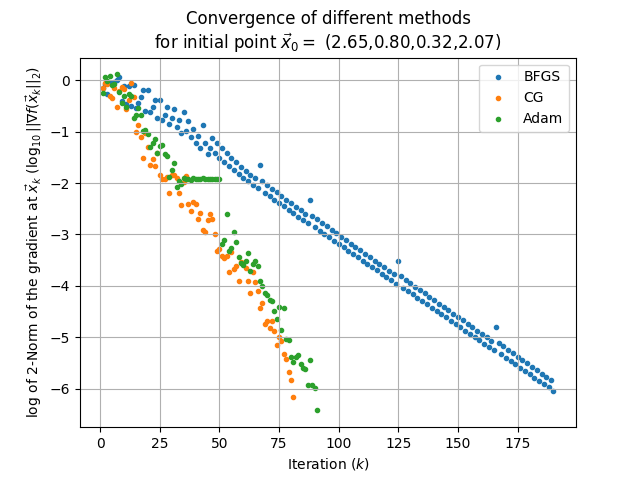

[[1.0001342 ]
 [1.4997322 ]
 [1.00012284]
 [1.49983288]]


In [31]:
##Test a random point for BFGS and CG and Adam

d = 4

x0 = np.random.random((d,1)).reshape(-1,1)*3
print(f'x0 = {x0.T}')

H = np.eye(d,d)

"""
H = sla.inv(Hes(x0))
eigs = sla.eigvals(H)
if np.any(eigs <= 0 ): H = H - np.min(eigs)*1.1*np.eye(2,2)
sla.eigvals(H)
"""

x, grads, _ = BFGS(x0, wheelerridge, H=H, get_step=wolfe_bisection, 
                   verbose=False, eps=1e-6, kmax=1000, gmethod=1)
x_CG, grads_CG, _ = CG(x0, wheelerridge, get_step=wolfe_bisection, 
                       eps=1e-6, kmax=1000, gmethod=1)
x_Adam, grads_Adam, _ = AdaM(x0, wheelerridge, get_step=wolfe_bisection, 
                       eps=1e-6, kmax=1000, gmethod=1, gamma1=0.25, gamma2=0.25)

fig, ax = plt.subplots()

ax.scatter(np.arange(1,len(grads)+1), np.log10(grads), marker='.', label='BFGS')
ax.scatter(np.arange(1,len(grads_CG)+1), np.log10(grads_CG), marker='.', label='CG')
ax.scatter(np.arange(1,len(grads_Adam)+1), np.log10(grads_Adam), marker='.', label='Adam')
ax.grid()
ax.legend()
xvec = '('
for j,xj in enumerate(x0[:,0]):
    xvec+=f'{xj:.2f}'
    if j==x.shape[0]-1: xvec+=')'
    else: xvec+=','

ax.set(xlabel=r'Iteration ($k$)', 
       ylabel=r'log of 2-Norm of the gradient at $\vec{x}_k$ ($\log_{10}||\nabla f(\vec{x}_k||_2$)',
       title='Convergence of different methods\n' + r'for initial point $\vec{x}_0 =$ ' + xvec)

plt.show()

print(x)

In [32]:
#Testing BFGS
its = []
f_calls = []
N = 200
kmax = d*250
gradsBFGS = np.empty(shape=(N,kmax))

print('Warning this may take a minute...\n')
for i in range(N):
    x0 = np.random.random((d,1)).reshape(-1,1)*3
    H = np.eye(d,d)
    """
    H = sla.inv(Hes(x0))
    eigs = sla.eigvals(H)
    if np.any(eigs <= 0 ): H = H - np.min(eigs)*1.1*np.eye(2,2)
    sla.eigvals(H)
    """
    x, grads, obj_calls = BFGS(x0, wheelerridge, H=H, get_step=wolfe_bisection, 
                   verbose=False, eps=1e-6, kmax=kmax, gmethod=1)
    
    #Exact min is the vector of alternating 1 and 1.5 if even
    #vector of 1.5 and 1 if odd
    x_ex = np.empty_like(x)
    for j in range(d):
        if d%2 == 0:
            if j%2 == 0: x_ex[j] = 1.
            else: x_ex[j] = 1.5
        else:
            if j%2 == 0: x_ex[j] = 1.5
            else: x_ex[j] = 1.

    if sla.norm(x - x_ex) < 0.01:
        its.append(len(grads))
        f_calls.append(obj_calls)
    
    gradsBFGS[i,:len(grads)] = np.array(grads)
    if len(grads) < N: gradsBFGS[i,len(grads):] = grads[-1]

its = np.array(its)
f_calls = np.array(f_calls)

print(f'stats for BFGS in {d} dimensions:') 
print('number of iterations...')
print(f'mean: {np.mean(its):.0f}')
print(f'max: {np.max(its)}')
print(f'min: {np.min(its)}')

print()

print('number of function calls...')
print(f'mean: {np.mean(f_calls):.0f}')
print(f'max: {np.max(f_calls)}')
print(f'min: {np.min(f_calls)}')

print(f'number of converged runs: {its.size}/{N}')

Warning this may take a minute...

stats for BFGS in 4 dimensions:
number of iterations...
mean: 173
max: 221
min: 113

number of function calls...
mean: 1216
max: 1551
min: 795
number of converged runs: 200/200


In [33]:
#Testing Conj. Grad.
its = []
f_calls = []
N = 200
gradsCG = np.empty(shape=(N,kmax))

print('Warning this may take a while...\n')
for i in range(N):
    x0 = np.random.random((d,1)).reshape(-1,1)*3
    x, grads, obj_calls = CG(x0, wheelerridge, get_step=wolfe_bisection, 
                             gmethod=1, kmax=kmax, eps=1e-6)
    
    #Exact min is the vector of alternating 1 and 1.5 if even
    #vector of 1.5 and 1 if odd
    x_ex = np.empty_like(x)
    for j in range(d):
        if d%2 == 0:
            if j%2 == 0: x_ex[j] = 1.
            else: x_ex[j] = 1.5
        else:
            if j%2 == 0: x_ex[j] = 1.5
            else: x_ex[j] = 1.

    if sla.norm(x - x_ex) < 0.01:
        its.append(len(grads))
        f_calls.append(obj_calls)

    gradsCG[i,:len(grads)] = np.array(grads)
    if len(grads) < N: gradsCG[i,len(grads):] = grads[-1]

its = np.array(its)
#f_calls = np.array(f_calls)

print(f'stats for Conj. Grad. in {d} dimensions')
print('number of iterations...')
print(f'mean: {np.mean(its):.0f}')
print(f'max: {np.max(its)}')
print(f'min: {np.min(its)}')

print()

print('number of function calls...')
print(f'mean: {np.mean(f_calls):.0f}')
print(f'max: {np.max(f_calls)}')
print(f'min: {np.min(f_calls)}')

print(f'number of converged runs: {its.size}/{N}')

Warning this may take a while...

stats for Conj. Grad. in 4 dimensions
number of iterations...
mean: 68
max: 104
min: 39

number of function calls...
mean: 483
max: 732
min: 277
number of converged runs: 200/200


In [34]:
#Testing Adam
its = []
f_calls = []
N = 200
gradsAdam = np.empty(shape=(N,kmax))

print('Warning this may take a while...\n')
for i in range(N):
    x0 = np.random.random((d,1)).reshape(-1,1)*3
    x, grads, obj_calls = AdaM(x0, wheelerridge, get_step=wolfe_bisection, gamma1=0.1, gamma2=0.1,
                               gmethod=1, kmax=kmax, eps=1e-6)
    
    #Exact min is the vector of alternating 1 and 1.5 if even
    #vector of 1.5 and 1 if odd
    x_ex = np.empty_like(x)
    for j in range(d):
        if d%2 == 0:
            if j%2 == 0: x_ex[j] = 1.
            else: x_ex[j] = 1.5
        else:
            if j%2 == 0: x_ex[j] = 1.5
            else: x_ex[j] = 1.

    if sla.norm(x - x_ex) < 0.01:
        its.append(len(grads))
        f_calls.append(obj_calls)

    gradsAdam[i,:len(grads)] = np.array(grads)
    if len(grads) < N: gradsAdam[i,len(grads):] = grads[-1]

its = np.array(its)
#f_calls = np.array(f_calls)

print(f'stats for Adam in {d} dimensions')
print('number of iterations...')
print(f'mean: {np.mean(its):.0f}')
print(f'max: {np.max(its)}')
print(f'min: {np.min(its)}')

print()

print('number of function calls...')
print(f'mean: {np.mean(f_calls):.0f}')
print(f'max: {np.max(f_calls)}')
print(f'min: {np.min(f_calls)}')

print(f'number of converged runs: {its.size}/{N}')

Warning this may take a while...

stats for Adam in 4 dimensions
number of iterations...
mean: 134
max: 280
min: 43

number of function calls...
mean: 943
max: 1964
min: 305
number of converged runs: 189/200


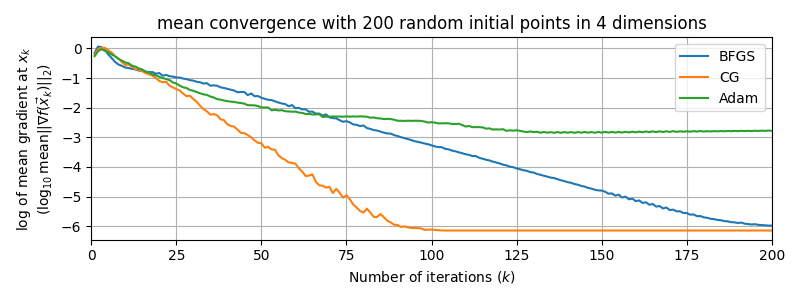

In [36]:
fig, ax = plt.subplots(layout='tight')
fig.set_size_inches(8,3)
fig.set_dpi(300)

ax.plot(np.arange(kmax)+1, np.log10(np.mean(gradsBFGS, axis=0)), label='BFGS')
ax.plot(np.arange(kmax)+1, np.log10(np.mean(gradsCG, axis=0)), label='CG')
ax.plot(np.arange(kmax)+1, np.log10(np.mean(gradsAdam, axis=0)), label='Adam')
ax.grid()
ax.legend()

ax.set(title=f'mean convergence with {N} random initial points in {d} dimensions',
       xlabel=r'Number of iterations ($k$)', 
       ylabel=r'log of mean gradient at $x_k$' +'\n'+r'($\log_{10}\mathrm{mean}||\nabla f(\vec{x}_k)||_2$)')

ax.set_xlim(0,200)

plt.show()